In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('seaborn')
from lifelines.utils import concordance_index

In [2]:
# choose random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:25]

In [3]:
from sksurv.datasets import load_gbsg2

X, y = load_gbsg2()

In [4]:
# function to transform y (a numpy nd array) to a dataframe
def target2df(y):
    event = [y[i][0] for i in range(len(y))]
    time = [y[i][1] for i in range(len(y))]
    df_y = pd.DataFrame(data={'time': time, 'cens': event})
    return df_y

In [5]:
# show the first 10 rows
df_y = target2df(y)
df_y.head(9)

,time,cens
0,1814.0,True
1,2018.0,True
2,712.0,True
3,1807.0,True
4,772.0,True
5,448.0,True
6,2172.0,False
7,2161.0,False
8,471.0,True


In [6]:
X.head(9)

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0
5,32.0,13.0,no,Pre,24.0,0.0,III,57.0
6,59.0,0.0,yes,Post,2.0,181.0,II,8.0
7,65.0,25.0,no,Post,1.0,192.0,II,16.0
8,80.0,59.0,no,Post,30.0,0.0,II,39.0


In [7]:
# number of samples, number of features/covariables
print(f'samples: {X.shape[0]}')
print(f'features/covariables: {X.shape[1]}\n')
print(f'right censored samples: {len(df_y.query("cens == False"))}')
print(f'percentage of right censored samples: {100*len(df_y.query("cens == False"))/len(df_y):.1f}%')

samples: 686
features/covariables: 8

right censored samples: 387
percentage of right censored samples: 56.4%


In [8]:
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=42)

print(f'Number of training samples: {len(y_trn)}')
print(f'Number of validation samples: {len(y_val)}')

Number of training samples: 514
Number of validation samples: 172


In [9]:
scaling_cols = [c for c in X.columns if X[c].dtype.kind in ['i', 'f']]
scaling_cols

['age', 'estrec', 'pnodes', 'progrec', 'tsize']

In [10]:
cat_cols = [c for c in X.columns if X[c].dtype.kind not in ["i", "f"]]
cat_cols

['horTh', 'menostat', 'tgrade']

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    [('cat-preprocessor', OrdinalEncoder(), cat_cols),
    ('standard-scaler', StandardScaler(), scaling_cols)],
    remainder='passthrough', sparse_threshold=0)

## Cox proportional hazards model

In [12]:
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
cox.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_val["cens"], y_val["time"], cox.predict(X_val))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.635


In [13]:
cox_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
    cox.fit(X_trn, y_trn)
    cox_scores.append(cox.score(X_val, y_val))

In [14]:
df_cox_scores = pd.DataFrame({'Seed': seeds, 'Cox PH' : cox_scores})
df_cox_scores.to_csv('scores.csv', mode='w')

## Random Survival Forest

In [15]:
from sklearn.pipeline import make_pipeline
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))

rsf.fit(X_trn, y_trn)

ci_rsf = concordance_index_censored(y_val["cens"], y_val["time"], rsf.predict(X_val))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.740


In [16]:
rsf_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))
    rsf.fit(X_trn, y_trn)
    rsf_scores.append(rsf.score(X_val, y_val))

In [17]:
df_csv = pd.read_csv('scores.csv')
df_csv['RSF'] = pd.Series(rsf_scores)
df_csv.to_csv('scores.csv', mode='w')

## Gradient Boosting

In [18]:
from sklearn.pipeline import make_pipeline
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gbc = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(random_state=42))

gbc.fit(X_trn, y_trn)

ci_gbc = concordance_index_censored(y_val["cens"], y_val["time"], gbc.predict(X_val))
print(f'The c-index of Gradient Boosting Cox PH is given by {ci_gbc[0]:.3f}')

The c-index of Gradient Boosting Cox PH is given by 0.724


In [19]:
gbc_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    gbc = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(random_state=42))
    gbc.fit(X_trn, y_trn)
    gbc_scores.append(gbc.score(X_val, y_val))

In [20]:
df_csv = pd.read_csv('scores.csv')
df_csv['GBC'] = pd.Series(gbc_scores)
df_csv.to_csv('scores.csv', mode='w')

## Weibull AFT

In [21]:
columns_encoded = X_trn.columns
columns_encoded

Index(['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade',
       'tsize'],
      dtype='object')

In [22]:
X_trn1 = preprocessor.fit_transform(X_trn)
X_val1 = preprocessor.transform(X_val)

In [23]:
X_trn1 = pd.DataFrame(X_trn1, columns=columns_encoded)
X_val1 = pd.DataFrame(X_val1, columns=columns_encoded)

In [24]:
X_trn1['cens'] = y_trn['cens']
X_val1['cens'] = y_val['cens']

In [25]:
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import WeibullAFTFitter

WeibullAFTRegression = sklearn_adapter(WeibullAFTFitter, event_col='cens')
sk_aft = WeibullAFTRegression()
sk_aft.fit(X_trn1, y_trn['time'])
ci_aft = sk_aft.score(X_val1, y_val['time'])
print(f'The c-index of Weibull AFT is given by {ci_aft:.3f}')

The c-index of Weibull AFT is given by 0.717


In [26]:
aft_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    X_trn1 = pd.DataFrame(X_trn1, columns=columns_encoded)
    X_val1 = pd.DataFrame(X_val1, columns=columns_encoded)
    X_trn1['cens'] = y_trn['cens']
    X_val1['cens'] = y_val['cens']
  
    WeibullAFTRegression = sklearn_adapter(WeibullAFTFitter, event_col='cens')
    sk_aft = WeibullAFTRegression()
    sk_aft.fit(X_trn1, y_trn['time'])
    
    aft_scores.append(sk_aft.score(X_val1, y_val['time']))

In [27]:
df_csv = pd.read_csv('scores.csv')
df_csv['AFT'] = pd.Series(aft_scores)
df_csv.to_csv('scores.csv', mode='w')

## Aalen's additive model

In [28]:
from lifelines import AalenAdditiveFitter

AalenAdditiveRegression = sklearn_adapter(AalenAdditiveFitter, event_col='cens')
sk_aa = AalenAdditiveRegression()
sk_aa.fit(X_trn1, y_trn['time'])
ci_aa = sk_aa.score(X_val1, y_val['time'])
print(f"The c-index of Aalen's additive model is given by {ci_aa:.3f}")

The c-index of Aalen's additive model is given by 0.730


In [29]:
aa_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    X_trn1 = pd.DataFrame(X_trn1, columns=columns_encoded)
    X_val1 = pd.DataFrame(X_val1, columns=columns_encoded)
    X_trn1['cens'] = y_trn['cens']
    X_val1['cens'] = y_val['cens']
  
    AalenAdditiveRegression = sklearn_adapter(AalenAdditiveFitter, event_col='cens')
    sk_aa = AalenAdditiveRegression()
    sk_aa.fit(X_trn1, y_trn['time'])
    
    aa_scores.append(sk_aa.score(X_val1, y_val['time']))

In [30]:
df_csv = pd.read_csv('scores.csv')
df_csv['Aalen'] = pd.Series(aa_scores)
df_csv.to_csv('scores.csv', mode='w')

## Cox Randomized Search

In [31]:
# print("The hyper-parameters for the full-pipeline are:")
# for param_name in rsf.get_params().keys():
#     print(param_name)
    
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'coxphsurvivalanalysis__alpha': reciprocal(0.1, 100),
}

model_random_search = RandomizedSearchCV(cox, param_distributions=param_distributions, n_iter=50, n_jobs=-1, cv=5, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of Cox using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_val, y_val):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of Cox using a RandomizedSearchCV is 0.715
The best set of parameters is: {'coxphsurvivalanalysis__alpha': 78.86714129990492}


In [32]:
model_random_search.best_params_

{'coxphsurvivalanalysis__alpha': 78.86714129990492}

In [33]:
cox_rs_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    cox_rs = make_pipeline(preprocessor, CoxPHSurvivalAnalysis(alpha=78.86714129990492))
    cox_rs.fit(X_trn, y_trn)
    cox_rs_scores.append(cox_rs.score(X_val, y_val))

In [34]:
df_csv = pd.read_csv('scores.csv')
df_csv['RS Cox'] = pd.Series(cox_rs_scores)
df_csv.to_csv('scores.csv', mode='w')

## RSF Randomized Search

In [35]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(
    rsf, param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=5, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_val, y_val):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of random survival forest using a RandomizedSearchCV is 0.727
The best set of parameters is: {'randomsurvivalforest__max_depth': 10, 'randomsurvivalforest__max_features': 4, 'randomsurvivalforest__min_samples_leaf': 13}


In [36]:
rsf_rs_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    rsf_rs = make_pipeline(preprocessor, RandomSurvivalForest(max_depth=10, max_features=4, min_samples_leaf=13, random_state=42))
    rsf_rs.fit(X_trn, y_trn)
    rsf_rs_scores.append(rsf_rs.score(X_val, y_val))

In [37]:
df_csv = pd.read_csv('scores.csv')
df_csv['RS RSF'] = pd.Series(rsf_rs_scores)
df_csv.to_csv('scores.csv', mode='w')

## Gradient Boostin Randomized Search

In [38]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'gradientboostingsurvivalanalysis__learning_rate': reciprocal(0.001, 1),
    'gradientboostingsurvivalanalysis__max_depth': reciprocal_int(5, 50),
    'gradientboostingsurvivalanalysis__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(gbc, param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=5, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of gradient boosting Cox PH using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_val, y_val):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

c:\users\cami_\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The c-index of gradient boosting Cox PH using a RandomizedSearchCV is 0.718
The best set of parameters is: {'gradientboostingsurvivalanalysis__learning_rate': 0.04366473592979633, 'gradientboostingsurvivalanalysis__max_depth': 7, 'gradientboostingsurvivalanalysis__min_samples_leaf': 35}


In [39]:
gbc_rs_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    gbc_rs = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(learning_rate=0.04366473592979633, \
                                                                         max_depth=7, min_samples_leaf=35, \
                                                                         random_state=42))
    gbc_rs.fit(X_trn, y_trn)
    gbc_rs_scores.append(gbc_rs.score(X_val, y_val))

In [40]:
df_csv = pd.read_csv('scores.csv')
df_csv['RS GBC'] = pd.Series(gbc_rs_scores)
df_csv.to_csv('scores.csv', mode='w')

## DeepSurv

In [41]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel

structure = [ {'activation': 'ReLU', 'num_units': 60}, {'activation': 'ReLU', 'num_units': 10}, ]

# Building the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_trn1, y_trn["time"], y_trn["cens"])

ci_deepsurv = concordance_index_censored(y_val["cens"], y_val["time"], nonlinear_coxph.predict_risk(X_val1))

print(f'The c-index of DeepSurv is given by {ci_deepsurv[0]:.3f}')


The c-index of DeepSurv is given by 0.874


In [42]:
nlc_scores = []

for _seed in seeds:
    
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_trn1, y_trn["time"], y_trn["cens"])
    nlc_scores.append(concordance_index_censored(y_val['cens'], y_val["time"], nonlinear_coxph.predict_risk(X_val1)))

% Completion: 100%|**********************************************|Loss: 1288.25
% Completion: 100%|**********************************************|Loss: 1237.99
% Completion: 100%|**********************************************|Loss: 1223.93
% Completion: 100%|**********************************************|Loss: 1232.19
% Completion: 100%|**********************************************|Loss: 1280.76
% Completion: 100%|**********************************************|Loss: 1195.99
% Completion: 100%|**********************************************|Loss: 1231.76
% Completion: 100%|**********************************************|Loss: 1281.86
% Completion: 100%|**********************************************|Loss: 1281.05
% Completion: 100%|**********************************************|Loss: 1215.01
% Completion: 100%|**********************************************|Loss: 1216.43
% Completion: 100%|**********************************************|Loss: 1260.15
% Completion: 100%|*********************

In [43]:
nlc_scores = [nlc_scores[i][0] for i in range(np.shape(nlc_scores)[0])]
df_csv = pd.read_csv('scores.csv')
df_csv['DeepSurv'] = pd.Series(nlc_scores)
df_csv.to_csv('scores.csv', mode='w')

## **RSF Adaptive NN**

In [44]:
#df_rsfann = pd.read_csv(r'rsfann_experiments10_cv(5,1)_cum_haz_table.csv')
#rsfann_scores = df_rsfann['cindex']
#df_csv = pd.read_csv('scores.csv')
#df_csv['RSFANN'] = pd.Series(rsfann_scores)
#df_csv.to_csv('scores.csv', mode='w')

In [45]:
X_trn1 = preprocessor.fit_transform(X_trn)
X_val1 = preprocessor.transform(X_val)

y_trn1 = np.zeros((514,2))
for i in range(514):
    y_trn1[i,0] = y_trn['time'][i]
    y_trn1[i,1] = y_trn['cens'][i]

y_val1 = np.zeros((172,2))

for i in range(172):
    y_val1[i,0] = y_val['time'][i]
    y_val1[i,1] = y_val['cens'][i]   
    
sorted_y_val = np.sort(np.unique(y_val1[:, 0]))

In [46]:
n_estimators = [50, 100]
max_depth=3
train_random_seeds_rsfann = 1126495081
rng = np.random.RandomState(92837912)

In [47]:
from LearningRSFANN import RandomSurvivalForestANN

surv_model = RandomSurvivalForestANN(n_estimators=50,max_depth=max_depth,min_samples_leaf=3,random_state=rng,n_jobs=-1)
surv_model.fit(X_trn1, y_trn1)

cum_haz = surv_model.predict_cum_haz(X_val1 ,sorted_y_val, presorted_times=True)
cum_hazard_scores = cum_haz.sum(axis=1)
ci_rsfann = concordance_index(y_val1[:, 0], -cum_hazard_scores, y_val1[:, 1]) 
print(f'The c-index of Random Survival Forest ANN is given by {ci_rsfann:.3f}')

The c-index of Random Survival Forest ANN is given by 0.697


In [48]:
rsfann_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    
    y_trn1 = np.zeros((514,2))
    for i in range(514):
        y_trn1[i,0] = y_trn['time'][i]
        y_trn1[i,1] = y_trn['cens'][i]

    y_val1 = np.zeros((172,2))
    for i in range(172):
        y_val1[i,0] = y_val['time'][i]
        y_val1[i,1] = y_val['cens'][i]
    
    
    sorted_y_val = np.sort(np.unique(y_val1[:, 0]))
    bol_y_val = np.array(y_val1[:,1], dtype=bool)   
    
    
    surv_model = RandomSurvivalForestANN(n_estimators=50,max_depth=max_depth,min_samples_leaf=3,random_state=rng,n_jobs=-1)
    surv_model.fit(X_trn1, y_trn1)
    
    
    cum_haz = surv_model.predict_cum_haz(X_val1 ,sorted_y_val, presorted_times=True)
    cum_hazard_scores = cum_haz.sum(axis=1)
    ci_rsfann = concordance_index(y_val1[:, 0], -cum_hazard_scores, y_val1[:, 1]) 
  

    rsfann_scores.append(ci_rsfann)

In [49]:
print(f'The c-index of Random Survival Forest ANN is given by {np.mean(rsfann_scores):.3f}')

The c-index of Random Survival Forest ANN is given by 0.688


In [50]:
df_csv = pd.read_csv('scores.csv')
df_csv['RSFANN'] = pd.Series(rsfann_scores)
df_csv.to_csv('scores.csv', mode='w')

## **Concordance Index Comparison**

In [51]:
print(f'Random Search RSF model: Mean c-index: {np.mean(rsf_rs_scores):.3f}, standard deviation: {np.std(rsf_rs_scores):.3f}')
print(f'Cox proportional hazards model: Mean c-index: {np.mean(cox_scores):.3f}, standard deviation: {np.std(cox_scores):.3f}')
print(f'Random Search Cox PH model: Mean c-index:{np.mean(cox_rs_scores):.3f}, standard deviation: {np.std(cox_rs_scores):.3f}')
print(f'Random Survival Forest model: Mean c-index: {np.mean(rsf_scores):.3f}, standard deviation: {np.std(rsf_scores):.3f}')
print(f'Gradient boosting Cox PH model: Mean c-index: {np.mean(gbc_scores):.3f}, standard deviation: {np.std(gbc_scores):.3f}')
print(f'Random Search Gradient Boosting model: Mean c-index:{np.mean(gbc_rs_scores):.3f}, standard deviation: {np.std(gbc_rs_scores):.3f}')
print(f'Non linear Cox PH model: Mean c-index: {np.mean(nlc_scores): .3f}, standard deviation: {np.std(nlc_scores):.3f}')
print(f'RSF Adaptative NN model: Mean c-index: {np.mean(rsfann_scores):.3f}, standard deviation: {np.std(rsfann_scores):.3f}')
print(f'Weibull AFT model: Mean c-index:{np.mean(aft_scores):.3f}, standard deviation: {np.std(aft_scores):.3f}')
print(f'Aalen additive model: Mean c-index:{np.mean(aa_scores):.3f}, standard deviation: {np.std(aa_scores):.3f}')

Random Search RSF model: Mean c-index: 0.693, standard deviation: 0.027
Cox proportional hazards model: Mean c-index: 0.673, standard deviation: 0.033
Random Search Cox PH model: Mean c-index:0.678, standard deviation: 0.030
Random Survival Forest model: Mean c-index: 0.694, standard deviation: 0.028
Gradient boosting Cox PH model: Mean c-index: 0.693, standard deviation: 0.027
Random Search Gradient Boosting model: Mean c-index:0.683, standard deviation: 0.028
Non linear Cox PH model: Mean c-index:  0.681, standard deviation: 0.026
RSF Adaptative NN model: Mean c-index: 0.688, standard deviation: 0.026
Weibull AFT model: Mean c-index:0.674, standard deviation: 0.033
Aalen additive model: Mean c-index:0.677, standard deviation: 0.030


Text(0.5, 1, 'Concordance Index Comparison')

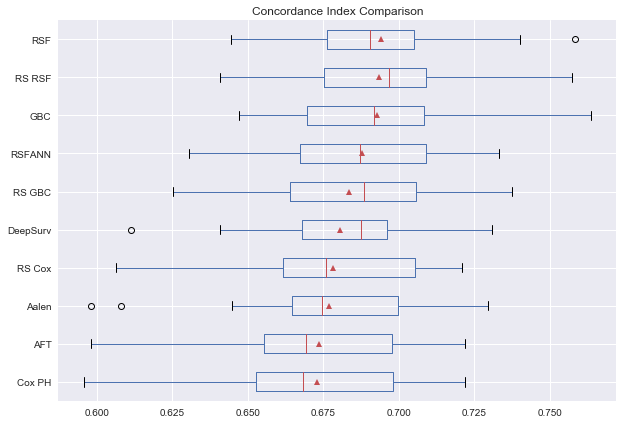

In [4]:
df_csv = pd.read_csv('scores.csv')
fig, ax = plt.subplots(figsize=(10,7))
df_csv.boxplot(ax=ax, column = ['Cox PH', 'AFT', 'Aalen', 'RS Cox', 'DeepSurv', 'RS GBC','RSFANN', 'GBC', 'RS RSF', 'RSF'], vert = False, showmeans = True)
plt.savefig('Scores.png', format='png', dpi=100)
plt.title('Concordance Index Comparison')

In [56]:
plt.savefig('Scores.png', format='png', dpi=100)

<Figure size 576x396 with 0 Axes>